In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [3]:
# import zipfile
# corpus_zip = zipfile.ZipFile('/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.zip', 'r')
# recipe_str = corpus_zip.read(corpus_zip.namelist()[0])
# recipe = json.loads(recipe_str)

In [4]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.json"
# op_file_path = "data/ing_density.csv"
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer1.json"
op_file_path = "../../data/ing_density.csv"

with open(filepath) as json_data:
    recipe = json.load(json_data)

In [5]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer2.json"
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer2.json"
with open(filepath) as json_data:
    recipe_images = json.load(json_data)

In [5]:
unit_abbreviation = { 'tbsp' : ["tablespoon"],
                      'tsp' : ['teaspoon'],
                     'ml' : ['milliliter'],
                     'cup' : ['cups','cup'],
                     'oz' : ['ounces','oz', 'ounce']
    
}

In [10]:
# # loading recipe
# dict_ingredients= recipe_load(n=2, recipe=recipe)
# df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
# df_combined_ing

In [6]:
# Set input file directory
ip_file_dir = "../../data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [7]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [8]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('../../data/embeddings/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('../../data/embeddings/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [9]:
# Get random recipe from the 1M recipe corpus
# i = random.randint(0, 1000000)
# print(i)
dict_ingredients= recipe_load_index(814427, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(float)


qty = Qty_normal_map(unit_abbreviation = unit_abbreviation, op_file_path= op_file_path)
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = df_combined_ing.groupby(by=['ingredient', 'normalized_unit'], 
                                               as_index = False)\
                                      .agg({'quantity': 'sum', 'Volume_in_ml': 'sum'})
#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


Recipe: My Mom's Potato Salad


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:54: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


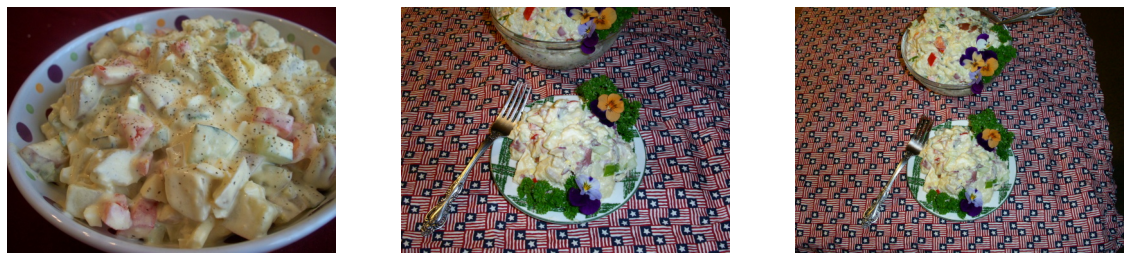

In [10]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == 'ca596d5fad':
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

In [16]:
recipe[814427]

{'ingredients': [{'text': '6 white potatoes or 6 red potatoes'},
  {'text': '1 red pepper'},
  {'text': '1 green pepper'},
  {'text': '1 Spanish onion (red onion)'},
  {'text': '4 eggs, boiled'},
  {'text': '2 cucumbers, remove the seeds (use the meat only)'},
  {'text': '2 12 cups Hellmanns Mayonnaise'},
  {'text': '13 cup Dijonnaise mustard (mom always used plain yellow ( i modified the recipe with the Dijonnaise) or 13 cup yellow mustard (mom always used plain yellow ( i modified the recipe with the Dijonnaise)'},
  {'text': '1 tablespoon horseradish'},
  {'text': 'salt and pepper'}],
 'url': 'http://www.food.com/recipe/my-moms-potato-salad-932',
 'partition': 'test',
 'title': "My Mom's Potato Salad",
 'id': 'ca596d5fad',
 'instructions': [{'text': 'Boil potatoes and cut into cubes, cool.'},
  {'text': 'Cut the vegetables and eggs up to whatever size you prefer.'},
  {'text': 'Combine veggies with potatoes and toss.'},
  {'text': 'Add mayo, mustard, horseradish, salt and pepper to 

In [17]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,Dijonnaise mustard or 13,cup,13.0,2925.0,"(None, None, )",NaN,NaN,
1,Hellmanns Mayonnaise,cup,12.0,2700.0,"(None, None, )",NaN,NaN,
2,Spanish onion,count,1.0,0.0,"(1.0, 242.0, cup)",1.0,242.0,cup
3,cucumbers,count,2.0,0.0,"(1.0, 159.0, cup)",1.0,159.0,cup
4,eggs,count,4.0,0.0,"(1.0, 34.0, white)",1.0,34.0,white
5,green pepper,count,1.0,0.0,"(1.0, 155.0, cup)",1.0,155.0,cup
6,horseradish,tbsp,1.0,15.0,"(1.0, 5.0, tsp)",1.0,5.0,tsp
7,red pepper,count,1.0,0.0,"(1.0, 155.0, cup)",1.0,155.0,cup
8,salt and pepper,,0.0,0.0,"(0.5, 92.0, cup chopped)",0.5,92.0,cup chopped
9,white potatoes or 6 red potatoes,count,6.0,0.0,"(None, None, )",NaN,NaN,


In [18]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients, 3)

rslt_df = group10[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value', 'package_weight_unit_of_measure','package_weight']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group10['tcin'].isin(ranked_match[i])] 
    ing = recipe_ingredients[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'ingredient']=ing
                break
       
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

#matching target database with recipe 
join_df = pd.merge(final_rslt_df, final_df, 
                   how = 'left', on = 'ingredient')

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price'])
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']]

[8.0, 8.0, 5.0, 6.0, 8.0, 7.0, 0, 0, 0, 2.0, 0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 0, 1, 1, 1, 0, 0, 0]


/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [19]:
display_df.head(4)

,tcin,ingredient,recommended_qty,price
10,14919619,cucumbers,0.0,2.39
9,13728423,cucumbers,2.0,0.55
11,15416571,cucumbers,2.0,3.79
2,12946184,dijonnaise mustard or,5.0,4.59


cucumbers
[14919619 13728423 15416571]


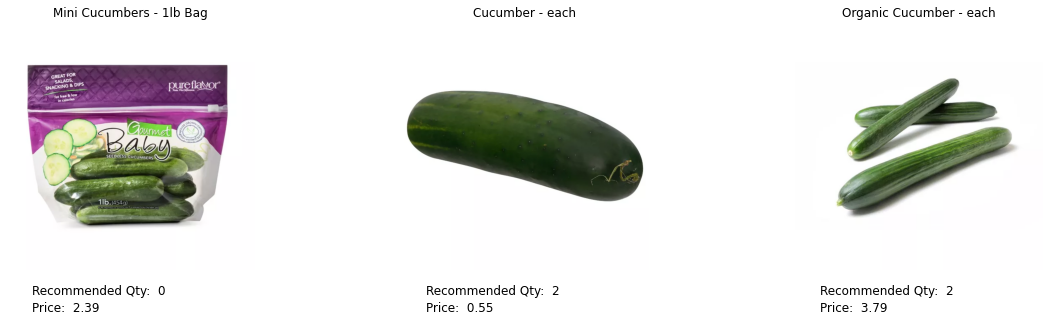

dijonnaise mustard or 
[12946184 13130556 13291404]


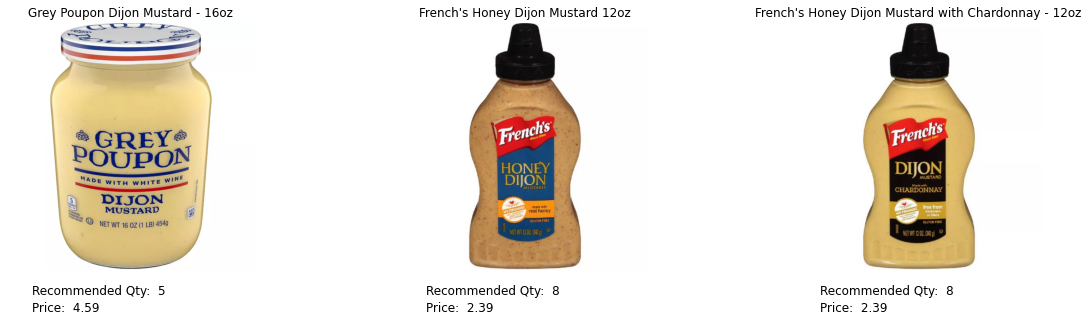

eggs
[51107510 81488495 51744135]


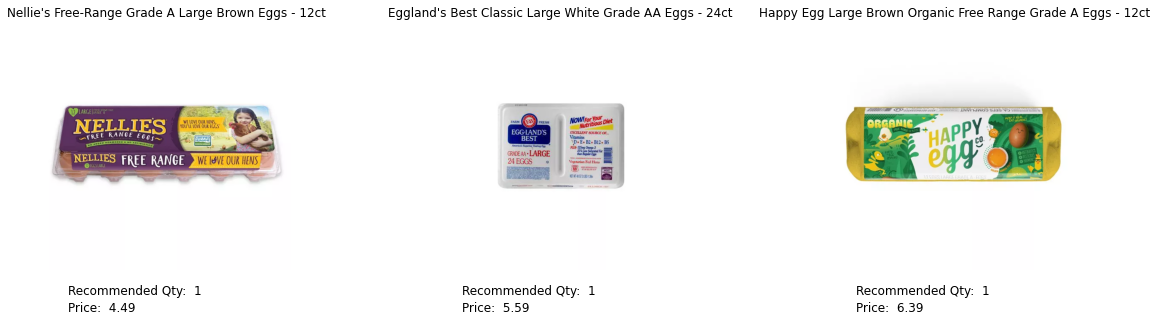

green pepper
[12921529 13728672 15293786]


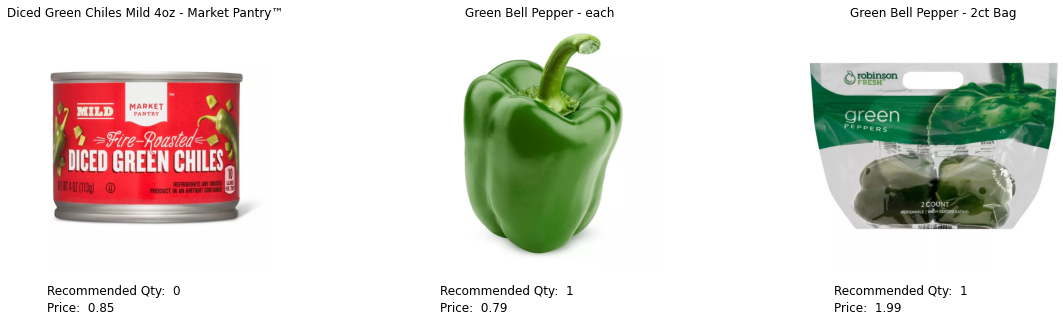

hellmanns mayonnaise
[50295219 13028013 16503530]


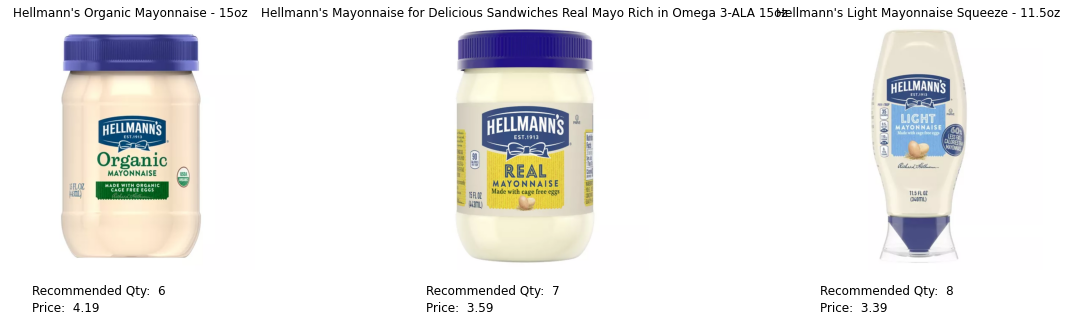

horseradish
[50474964 51068371 12935757]


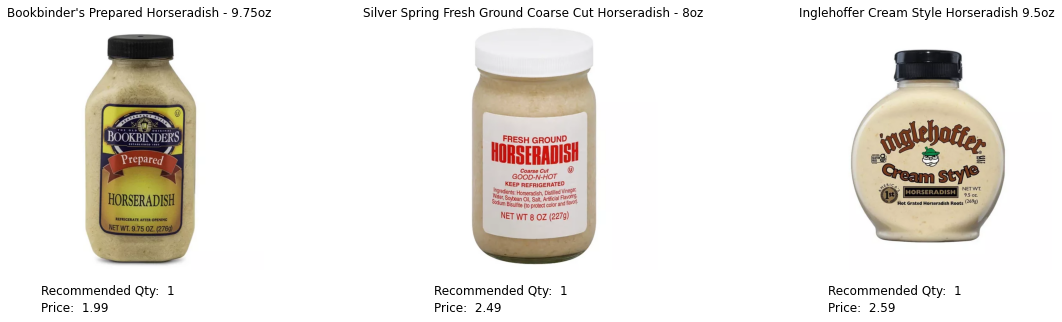

red pepper
[77584991 13478968 79502634]


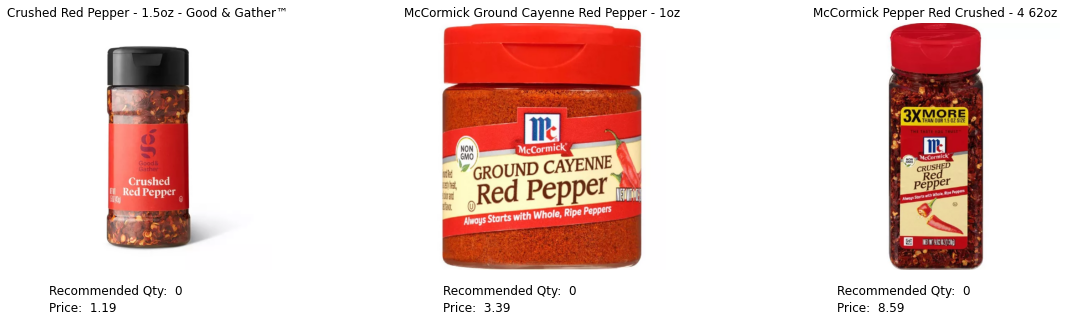

salt and pepper
[77588365 13170721 78096196]


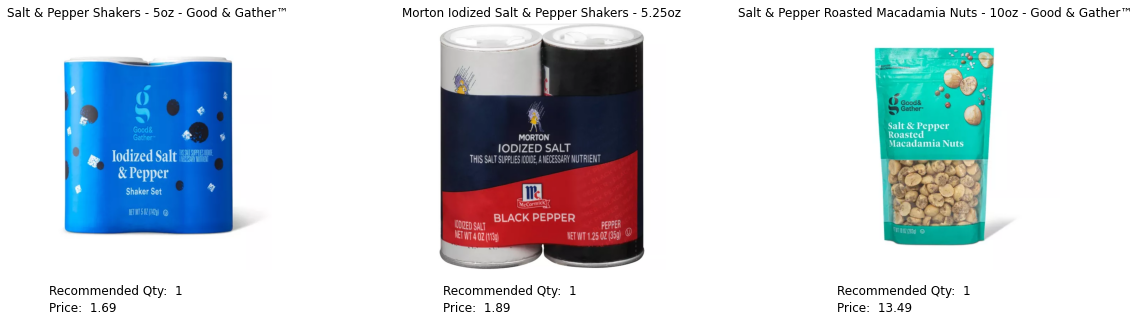

spanish onion
[47112082 51586655 47088172]


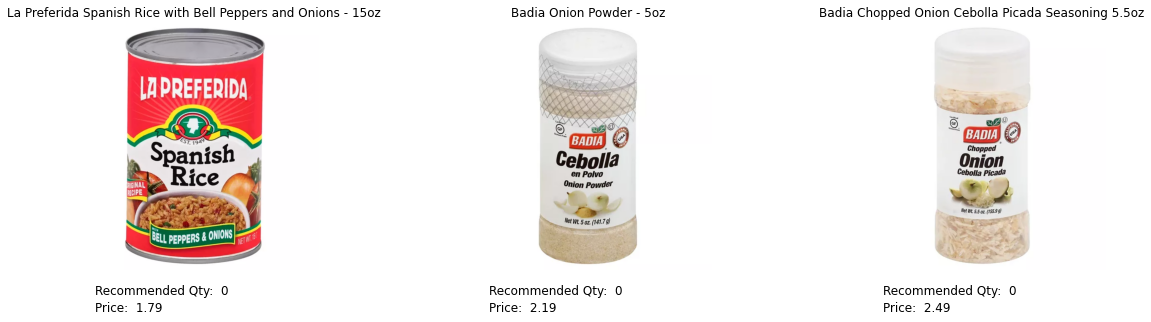

white potatoes or red potatoes
[77783876 14916878 14993270]


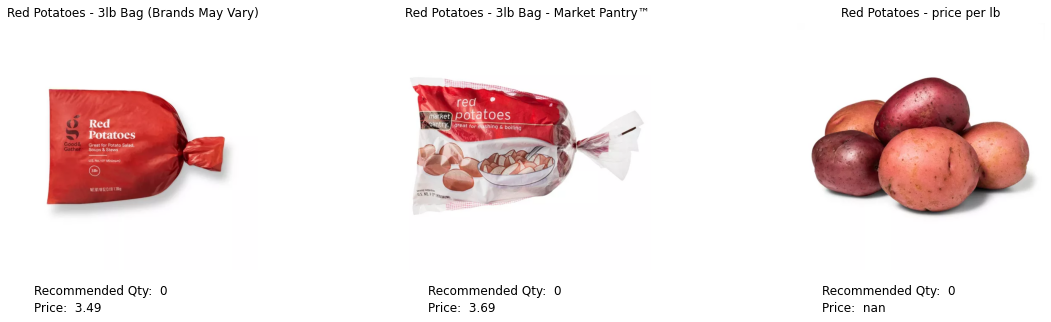

In [20]:
dp.display_products_df(display_df, 3)